#Download Dataset





{"username":"arsanymousafathy","key":"7dad8a66f62a0da359c47074cd914b32"}

In [1]:
!pip install opendatasets
import gzip
import opendatasets as od
#download given dataset for the original problem
od.download(
    "https://www.kaggle.com/datasets/dmitrybabko/speech-emotion-recognition-en", force=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: arsanymousafathy
Your Kaggle Key: ··········


100%|██████████| 987M/987M [00:36<00:00, 28.0MB/s]


In [2]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Imports

In [3]:
import numpy as np
import random
import copy
from scipy.spatial.distance import cdist
import math
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import librosa
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from IPython.display import Audio
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras import layers
from keras import models
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import OneHotEncoder


#Preprocessing Functions

##Main Preprocessing Function

In [4]:
def preprocess_audio(audio_data, sample_rate):
  #Noise Reduction
  cleaned_audio = spectral_subtraction(audio_data, 0.0000000005,  3)
  #Silence Removal
  #silenced = remove_silence(cleaned_audio)
  #Preemphasis  
  #peremph = preemphasis(cleaned_audio, 0.95)
  #Normalization
  #normalized_audio = normalize_audio(peremph)
  #Truncate
  preprocessed_audio = truncate_pad(cleaned_audio, 3)
  return preprocessed_audio

In [5]:
def preprocess_audio_mel(audio_data, sample_rate):
  #Noise Reduction
  cleaned_audio = spectral_subtraction(audio_data, 0.0000000005,  3)
  #Silence Removal
  silenced = remove_silence(cleaned_audio)
  #Preemphasis  
  peremph = preemphasis(silenced, 0.95)
  #Normalization
  normalized_audio = normalize_audio(peremph)
  #Truncate
  preprocessed_audio = truncate_pad(normalized_audio, 1.024)
  return preprocessed_audio

##Truncate Audio

In [6]:
def truncate_pad(audio_data, desired_duration):
  # Calculate the number of samples required for the desired duration
  num_samples = int(desired_duration * 16000)
  if len(audio_data) > num_samples:
    audio_data = audio_data[:num_samples]
  else:
    audio_data = np.pad(audio_data, (0, num_samples - len(audio_data)), 'constant')
  return audio_data

##Reduce Noise

In [7]:
def spectral_subtraction(audio, noise_threshold, alpha):
    # Compute the STFT of the audio
    audio_stft = librosa.stft(audio, n_fft=2048, hop_length=512)

    # Estimate the noise profile
    noise_stft = np.median(np.abs(audio_stft), axis=1)
    noise_stft = np.expand_dims(noise_stft, axis=1)

    # Apply spectral subtraction to the power spectrogram of the audio
    audio_power = np.abs(audio_stft)**2
    cleaned_power = audio_power - alpha * noise_stft
    cleaned_power[cleaned_power < noise_threshold] = noise_threshold

    # Invert the STFT to obtain the cleaned audio
    cleaned_stft = np.sqrt(cleaned_power) * np.exp(1j * np.angle(audio_stft))
    cleaned_audio = librosa.istft(cleaned_stft, hop_length=512)

    return cleaned_audio

##Remove Silence

In [8]:
def remove_silence(audio_data):
  # Trim silence
  audio_data_trimmed, _ = librosa.effects.trim(audio_data, top_db=20)
  return audio_data_trimmed

##Normalize Audio

In [9]:
def normalize_audio(audio):
    # Compute the mean and standard deviation of the audio signal
    audio_mean = np.mean(audio)
    audio_std = np.std(audio)

    # Normalize the audio signal
    if audio_std == 0:
      audio_std = 1e-6 # a small value
    normalized_audio = (audio - audio_mean) / audio_std

    return normalized_audio


##Preemphasis

In [10]:
def preemphasis(signal, alpha=0.95):
    # Apply preemphasis filter
    preemphasized_signal = signal - alpha * np.append(signal[0], signal[:-1])
    return preemphasized_signal

#Features Extraction Functions

##Time Features

In [11]:
def extract_features(data,sr,frame_length,hop_length):
    result=np.array([])
    
    result=np.hstack((result,
                      zero_crossing_rate(data,frame_length,hop_length),
                      rmse(data,frame_length,hop_length),
                      energy(data,frame_length,hop_length),
                      entropy_of_energy(data,frame_length,hop_length),
                      ##get_pitch_contour(data, sr, frame_length, hop_length),
                      #mfcc(data,sr,frame_length,hop_length),
                      spc(data,sr,frame_length,hop_length),
                      spc_rollof(data,sr,frame_length,hop_length)
                     ))
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sr).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

##Frequency Features

In [12]:
def extract_featuresFrequency(data,sample_rate, frame_length,hop_length):
    # ZCR
    result = np.array([])
    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    return result

##Zero Crossing Rate

In [13]:
def zero_crossing_rate(data, frame_length, non_overlapping_period):
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=non_overlapping_period)
    return np.squeeze(zero_crossing_rate)
"""
Zero Crossing Rate (ZCR): The rate at which the audio waveform changes from positive to negative or vice versa,
indicating how often the signal changes direction.
"""

'\nZero Crossing Rate (ZCR): The rate at which the audio waveform changes from positive to negative or vice versa,\nindicating how often the signal changes direction.\n'

##Energy

In [14]:
def energy(data, frame_length, non_overlapping_period):
    en = np.array([np.sum(np.power(np.abs(data[non_overlapping_period:non_overlapping_period+frame_length]), 2)) for hop in range(0, data.shape[0], non_overlapping_period)])
    return en / frame_length
"""
Energy: The amount of energy in each frame of the audio signal, which can give a sense of overall loudness or intensity.
"""

'\nEnergy: The amount of energy in each frame of the audio signal, which can give a sense of overall loudness or intensity.\n'

In [15]:
def entropy_of_energy(data, frame_length, non_overlapping_period):
    energies = energy(data, frame_length, non_overlapping_period)
    sum =  np.sum(energies) 
    if sum == 0:
      sum = 1e-6 # a small value
    energies /= sum
    entropy = 0.0
    energies_nozeroes = np.where(energies == 0, 1, energies)
    entropy -= energies_nozeroes * np.log2(energies_nozeroes)
    return entropy
"""
Entropy of Energy: The entropy of the energy distribution across frames, 
which can give a sense of how varied or uniform the energy is across the signal.
"""

'\nEntropy of Energy: The entropy of the energy distribution across frames, \nwhich can give a sense of how varied or uniform the energy is across the signal.\n'

##RMSE

In [16]:
def rmse(data, frame_length, non_overlapping_period):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=non_overlapping_period)
    return np.squeeze(rmse)
"""
Root Mean Square Energy (RMSE): The root-mean-square value of the audio waveform, which can provide a measure of overall loudness.
"""

'\nRoot Mean Square Energy (RMSE): The root-mean-square value of the audio waveform, which can provide a measure of overall loudness.\n'

##Pitch Contour

In [17]:
def get_pitch_contour(data, sr, frame_length, hop_length):
    # Extract pitch contour using YIN algorithm
    f0, voiced_flag, voiced_probs = librosa.pyin(data, fmin=75, fmax=300)
    pitch_mean = np.mean(f0[voiced_flag])
    pitch_std = np.std(f0[voiced_flag])
    if math.isnan(pitch_std):
      pitch_std = 0
    if math.isnan(pitch_mean):
      pitch_mean = 0  
    return pitch_mean,pitch_std

##MFCC

In [18]:
def mfcc(data, frame_length, hop_length, sr):
    frame_rate = 100
    mfcc_feature = librosa.feature.mfcc(y=data, n_fft = frame_length, sr=sr, hop_length = int(sr/frame_rate), n_mfcc = 13)
    return np.squeeze(mfcc_feature).flatten()

#Mel-Frequency Cepstral Coefficients (MFCCs): A set of coefficients that capture the shape of the spectral envelope of the signal, 
#which can provide information about the timbre or "color" of the sound.

##SPC

In [19]:
def spc(data, sr, frame_length, non_overlapping_period):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=non_overlapping_period)
    return np.squeeze(spectral_centroid)

In [20]:
def spc_rollof(data, sr, frame_length, non_overlapping_period):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=non_overlapping_period)
    return np.squeeze(spcrollof)
"""
Spectral Rolloff: The frequency below which a specified percentage of the total spectral energy lies, 
which can provide a measure of the "brightness" of the signal.
"""

'\nSpectral Rolloff: The frequency below which a specified percentage of the total spectral energy lies, \nwhich can provide a measure of the "brightness" of the signal.\n'

#Data Augmentation Functions

In [21]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5) * 2000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor):
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps=pitch_factor)

In [22]:
def Data_Augmentation(data):
    data, sample_rate = librosa.load(data,  sr=16000)
    # Ordinary Data
    preprocessed_audio = preprocess_audio(data, sample_rate)
    D = extract_features(preprocessed_audio,sample_rate, 2048, 512)
    RESULT = np.array(D)
    # Data + Noise
    preprocessed_audio = truncate_pad(data, 3)
    NOISE = noise(preprocessed_audio)
    N = extract_features(NOISE,sample_rate, 2048, 512)
    RESULT = np.vstack([RESULT,N])
    preprocessed_audio = truncate_pad(data, 3)
    #SHIFT
    SHIFT = shift(preprocessed_audio)
    SH = extract_features(SHIFT,sample_rate, 2048, 512)
    RESULT = np.vstack([RESULT,SH])
    preprocessed_audio = truncate_pad(data, 3)
    #PITCH
    PITCH = pitch(preprocessed_audio, sample_rate, 0.7)
    P = extract_features(PITCH,sample_rate, 2048, 512)
    RESULT = np.vstack((RESULT,P))
    return RESULT

#Load Dataset

In [23]:
def loadAudio(audio_path):
  # load the audio file as a NumPy array
  audio_data, sample_rate = librosa.load(audio_path, sr = 16000)
  # print the shape and duration of the audio data
  #print(f'Audio data shape: {audio_data.shape}')
  #print(f'Audio duration: {librosa.get_duration(y=audio_data, sr=sample_rate)} seconds')
  return audio_data, sample_rate

In [24]:
dataset_path='/content/speech-emotion-recognition-en/Crema'
dataset = []
for wav in os.listdir(dataset_path):
  audio_path = dataset_path + '/' + wav
  record=wav.partition(".wav")[0].split('_')
  print(record)
  id = record[0]
  sentence = record[1]
  emotion = record[2]
  intensity = record[3]
  dataset.append((id, sentence, emotion, intensity, dataset_path+'/'+wav))
df=pd.DataFrame(dataset)
df.rename(columns={0:'ID', 1: 'Sentence', 2: 'Emotion', 3:'Intensity', 4: 'Path'},inplace=True)

Streaming output truncated to the last 5000 lines.
['1034', 'ITS', 'ANG', 'XX']
['1009', 'IEO', 'HAP', 'MD']
['1064', 'TAI', 'NEU', 'XX']
['1018', 'WSI', 'DIS', 'XX']
['1069', 'IEO', 'FEA', 'MD']
['1054', 'TAI', 'FEA', 'XX']
['1061', 'TAI', 'HAP', 'XX']
['1072', 'IEO', 'DIS', 'LO']
['1081', 'IWW', 'DIS', 'XX']
['1010', 'IOM', 'DIS', 'XX']
['1016', 'TIE', 'DIS', 'XX']
['1047', 'IEO', 'DIS', 'MD']
['1037', 'ITH', 'ANG', 'XX']
['1075', 'ITH', 'ANG', 'XX']
['1086', 'TAI', 'DIS', 'XX']
['1045', 'TSI', 'DIS', 'XX']
['1048', 'IWW', 'ANG', 'XX']
['1005', 'ITH', 'ANG', 'XX']
['1075', 'DFA', 'NEU', 'XX']
['1012', 'MTI', 'SAD', 'XX']
['1059', 'DFA', 'DIS', 'XX']
['1002', 'IWL', 'HAP', 'XX']
['1015', 'ITH', 'ANG', 'XX']
['1053', 'IEO', 'SAD', 'LO']
['1084', 'DFA', 'NEU', 'XX']
['1029', 'TAI', 'HAP', 'XX']
['1050', 'IEO', 'NEU', 'XX']
['1021', 'MTI', 'DIS', 'XX']
['1015', 'IEO', 'ANG', 'MD']
['1062', 'ITS', 'ANG', 'XX']
['1017', 'WSI', 'NEU', 'XX']
['1086', 'IOM', 'FEA', 'XX']
['1090', 'IWW', 'NEU'

#Emotions Statistics

['HAP' 'FEA' 'DIS' 'ANG' 'SAD' 'NEU']
HAP    1271
FEA    1271
DIS    1271
ANG    1271
SAD    1271
NEU    1087
Name: Emotion, dtype: int64


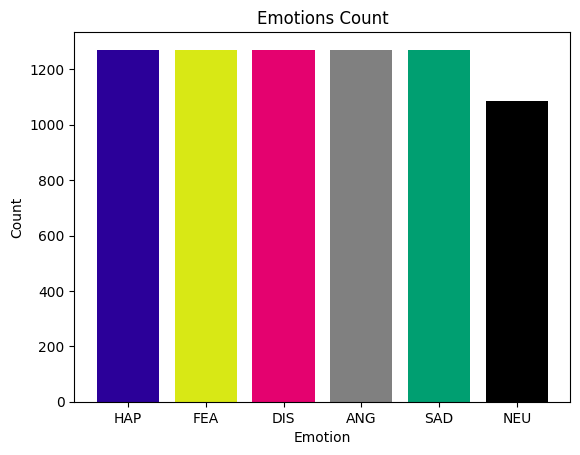

In [25]:
emotion_counts = df['Emotion'].value_counts()
print(df['Emotion'].unique())
print(emotion_counts)
emotions = np.array(emotion_counts.index)
colors = ['#2b0099', '#d8e815', '#e4026f', 'grey', '#009f71', 'black']
plt.bar(emotions, emotion_counts[0:len(emotion_counts)], color=colors)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Emotions Count')
plt.show()

#Show Samples of Data

ID                                                        1007
Sentence                                                   DFA
Emotion                                                    HAP
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 3796, dtype: object




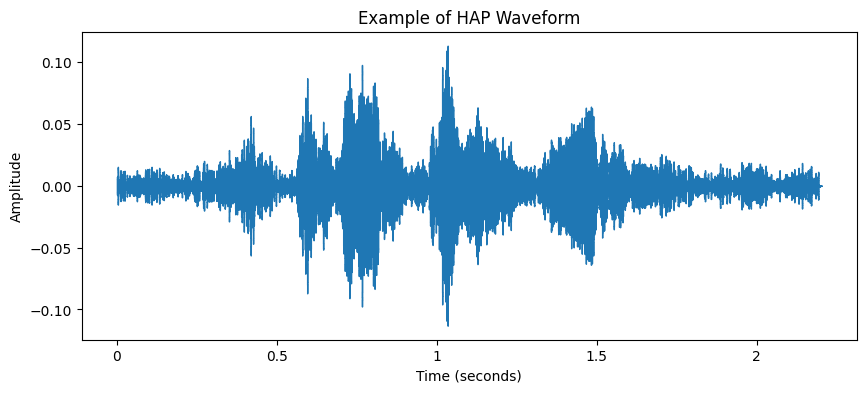




ID                                                        1046
Sentence                                                   IWL
Emotion                                                    FEA
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 2212, dtype: object




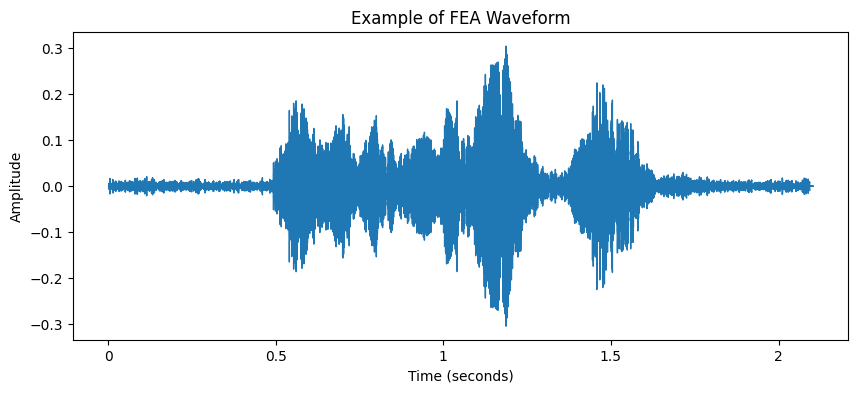




ID                                                        1039
Sentence                                                   IWW
Emotion                                                    DIS
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 5884, dtype: object




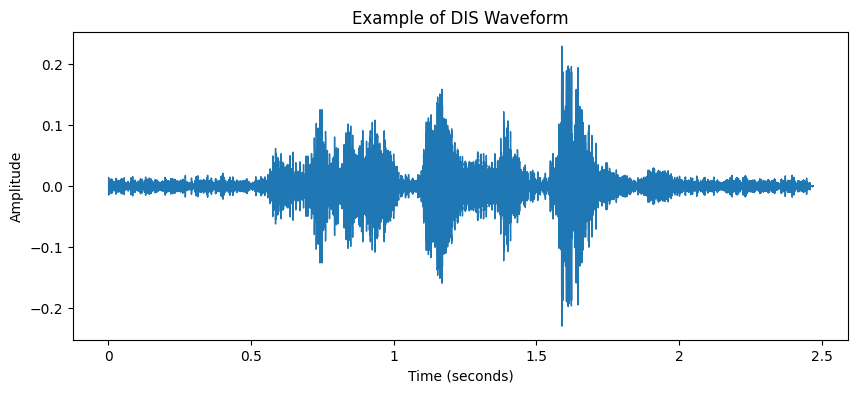




ID                                                        1057
Sentence                                                   DFA
Emotion                                                    ANG
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 6254, dtype: object




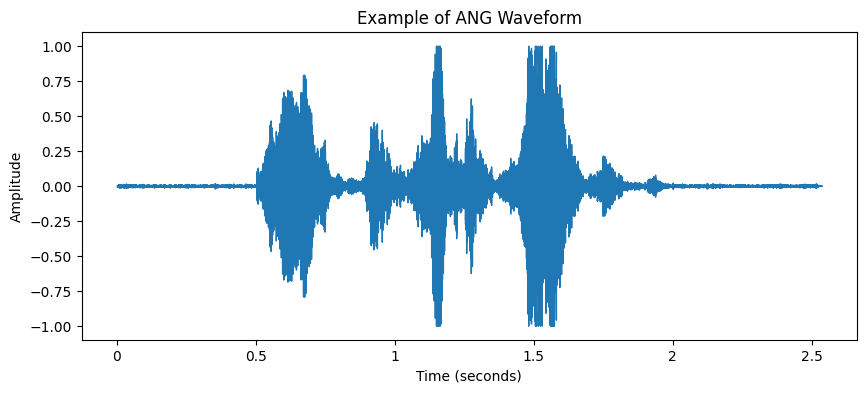




ID                                                        1028
Sentence                                                   MTI
Emotion                                                    SAD
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 2135, dtype: object




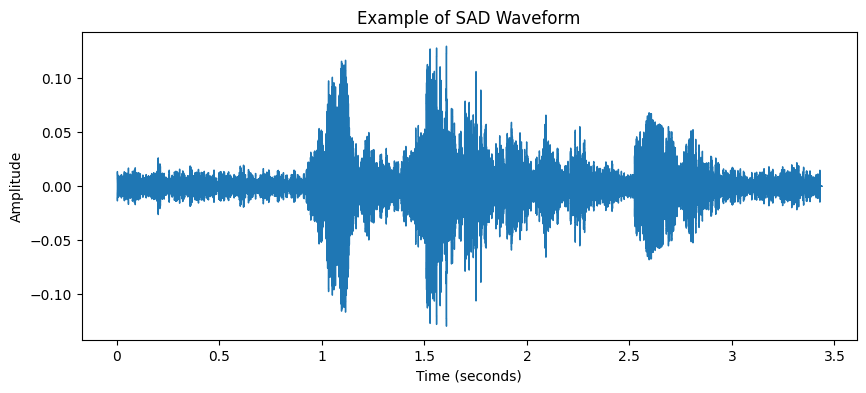




ID                                                        1063
Sentence                                                   ITS
Emotion                                                    NEU
Intensity                                                   XX
Path         /content/speech-emotion-recognition-en/Crema/1...
Name: 3408, dtype: object




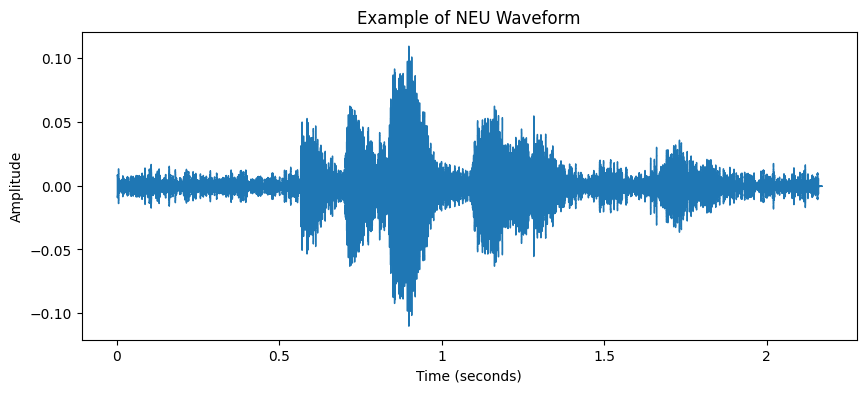

In [26]:
emotions = df['Emotion'].unique()
for i in range(len(emotions)):
  emotionIndices = df.index[df['Emotion'] == emotions[i]]
  random_index = random.choice(emotionIndices)
  print(df.loc[random_index])
  audio_path = df.loc[random_index]['Path']
  # Load audio file
  audio_data, sample_rate = loadAudio(audio_path)
  audio_player = Audio(data=audio_data, rate=sample_rate)
  print('\n')
  display(audio_player)
  # Plot waveform
  plt.figure(figsize=(10,4))
  plt.title(f'Example of {emotions[i]} Waveform')
  librosa.display.waveshow(y=audio_data, sr=sample_rate)
  plt.xlabel('Time (seconds)')
  plt.ylabel('Amplitude')
  plt.show()
  print('\n\n')


#Confusion Matrix Function

In [27]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Reds):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Splitting the dataset

In [28]:
training_set_df, testing_set_df = train_test_split(df,  test_size=0.3, random_state=42, stratify = df['Emotion'])

training_labels_df = df.loc[training_set_df.index]['Emotion']
testing_labels_df = df.loc[testing_set_df.index]['Emotion']

training_set_df, val_set_df = train_test_split(training_set_df,  test_size=0.05, random_state=42, stratify = training_labels_df)

training_labels_df = df.loc[training_set_df.index]['Emotion']
val_labels_df = df.loc[val_set_df.index]['Emotion']

#1D CNN

##Preparing train and test data

In [29]:
training_set = training_set_df
training_labels = training_labels_df
val_set = val_set_df
val_labels = val_labels_df
testing_set = testing_set_df
testing_labels=testing_labels_df

In [30]:
def prepare_train_data(data):
    features = []
    labels = []
    i=0
    for path,emotion in zip (data["Path"],data["Emotion"]):
        if i % 100 == 0:
          print(i)
        i = i+1
        DATA = Data_Augmentation(path)
        for sample in DATA:
            features.append(sample)
            labels.append(emotion)
    return features, labels

In [31]:
def prepare_test(data):
    dataset = []
    labels = []
    for path,emotion in zip (data["Path"],data["Emotion"]):
        #data, sample_rate = librosa.load(path, duration = 2.5, offset = 0.6)
        data, sample_rate = librosa.load(path,  sr=16000)
        preprocessed_audio = preprocess_audio(data, sample_rate)
        #preprocessed_audio = preprocess_audio(data, sample_rate)
        features = extract_features(preprocessed_audio, sample_rate, 2048, 512)
        dataset.append(features.tolist())
        labels.append(emotion)
    le = LabelEncoder()
# Apply label encoding to the label column
    labels_encoded = le.fit_transform(labels)
    labels_encoded = np.array(labels_encoded)
    return dataset, labels_encoded

In [32]:
print(training_set.shape)
print(training_labels.shape)

print(testing_set.shape)
print(testing_labels.shape)

print(val_set.shape)

(4948, 5)
(4948,)
(2233, 5)
(2233,)
(261, 5)


In [33]:
training_set, training_labels = prepare_train_data(training_set)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


In [34]:
le = LabelEncoder()
labels_encoded = le.fit_transform(training_labels)
labels_encoded = np.array(labels_encoded)
training_set_Final = np.empty([len(training_set), len(training_set[0])])
for i in range(len(training_set)):
  training_set_Final[i] = training_set[i]

In [35]:
testing_set, testing_labels = prepare_test(testing_set)

In [36]:
testing_set_Final = np.empty([len(testing_set), len(testing_set[0])])
for i in range(len(testing_set)):
  testing_set_Final[i] = testing_set[i]

In [37]:
val_set, val_labels = prepare_test(val_set)


In [38]:
val_set_Final = np.empty([len(val_set), len(val_set[0])])
for i in range(len(val_set)):
  val_set_Final[i] = val_set[i]

In [39]:
print(val_set_Final.shape)
print(val_labels.shape)
print(testing_set_Final.shape)
print(testing_labels.shape)
print(training_set_Final.shape)
training_labels = labels_encoded
print(training_labels.shape)

(261, 712)
(261,)
(2233, 712)
(2233,)
(19792, 712)
(19792,)


In [40]:
CNN_train = training_set_Final
CNN_train_labels = training_labels
CNN_test = testing_set_Final
CNN_test_labels = testing_labels
CNN_val = val_set_Final
CNN_val_labels = val_labels

In [41]:
from keras.utils import to_categorical

# Assuming your label encoded array is called 'training_labels'
num_classes = 6  # Number of classes in your dataset
CNN_train_labels = to_categorical(CNN_train_labels, num_classes)
CNN_val_labels = to_categorical(CNN_val_labels, num_classes)
CNN_test_labels = to_categorical(CNN_test_labels, num_classes)

In [42]:
# scaling our data with sklearn's Standard scaler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
scaler = StandardScaler()
CNN_train = scaler.fit_transform(CNN_train)
CNN_test = scaler.transform(CNN_test)
CNN_val = scaler.transform(CNN_val)

In [43]:
# making our data compatible to model.
CNN_train = np.expand_dims(CNN_train, axis=2)
CNN_test = np.expand_dims(CNN_test, axis=2)
CNN_val = np.expand_dims(CNN_val, axis=2)

In [44]:
print(CNN_train.shape)
print(CNN_train_labels.shape)
print(CNN_test.shape)
print(CNN_test_labels.shape)
print(CNN_val.shape)
print(CNN_val_labels.shape)

(19792, 712, 1)
(19792, 6)
(2233, 712, 1)
(2233, 6)
(261, 712, 1)
(261, 6)


## CNN Model

In [45]:
import tensorflow.keras.layers as L
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [46]:
earlystopping = EarlyStopping(monitor ="val_accuracy",mode = 'auto', patience = 8,restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [47]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [83]:
model=tf.keras.Sequential([
    L.Conv1D(512,kernel_size=3,  strides=1,padding='same', activation='relu',input_shape=(CNN_train.shape[1],1)),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),

    L.Conv1D(512,kernel_size=3,strides=1,padding='same',activation='relu'),
    L.BatchNormalization(),
    L.MaxPool1D(pool_size=5,strides=2,padding='same'),
    
    
    L.Flatten(),
    L.Dense(1024,activation='relu'),
    L.Dense(512,activation='relu'),
    L.Dense(6,activation='softmax')
])
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=["accuracy", f1_m])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 712, 512)          2048      
                                                                 
 batch_normalization_12 (Bat  (None, 712, 512)         2048      
 chNormalization)                                                
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 356, 512)         0         
 1D)                                                             
                                                                 
 conv1d_10 (Conv1D)          (None, 356, 512)          786944    
                                                                 
 batch_normalization_13 (Bat  (None, 356, 512)         2048      
 chNormalization)                                                
                                                      

In [84]:
history=model.fit(CNN_train, CNN_train_labels, epochs=50, validation_data=(CNN_val,CNN_val_labels), batch_size = 128, callbacks=[learning_rate_reduction, earlystopping])

Epoch 1/50
155/155 [==============================] - 35s 196ms/step - loss: 3.6614 - accuracy: 0.3279 - f1_m: 0.2423 - val_loss: 3.0855 - val_accuracy: 0.2107 - val_f1_m: 0.2462 - lr: 0.0010
Epoch 2/50
155/155 [==============================] - 29s 184ms/step - loss: 1.4405 - accuracy: 0.4288 - f1_m: 0.2971 - val_loss: 2.9789 - val_accuracy: 0.1877 - val_f1_m: 0.1914 - lr: 0.0010
Epoch 3/50
155/155 [==============================] - 29s 185ms/step - loss: 1.3590 - accuracy: 0.4595 - f1_m: 0.3400 - val_loss: 1.8000 - val_accuracy: 0.3103 - val_f1_m: 0.3205 - lr: 0.0010
Epoch 4/50
155/155 [==============================] - 29s 187ms/step - loss: 1.2866 - accuracy: 0.4873 - f1_m: 0.3789 - val_loss: 1.4685 - val_accuracy: 0.4521 - val_f1_m: 0.4025 - lr: 0.0010
Epoch 5/50
155/155 [==============================] - 29s 185ms/step - loss: 1.2426 - accuracy: 0.5118 - f1_m: 0.4185 - val_loss: 1.3241 - val_accuracy: 0.4904 - val_f1_m: 0.3764 - lr: 0.0010
Epoch 6/50
155/155 [====================

##Test Accuracy

In [85]:
accuracy = model.evaluate(CNN_test, CNN_test_labels)

# Print the accuracy
print("Test Accuracy:", accuracy)

70/70 [==============================] - 1s 18ms/step - loss: 1.3848 - accuracy: 0.5275 - f1_m: 0.4888
Test Accuracy: [1.3848109245300293, 0.5275413990020752, 0.48880621790885925]


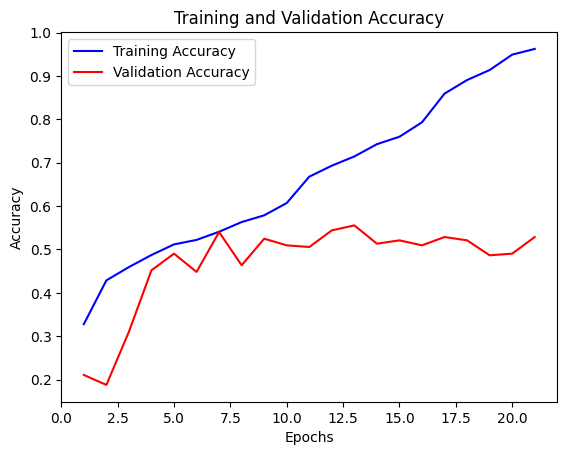

In [86]:
import matplotlib.pyplot as plt

# Get the accuracy values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##Confusion Matrix

In [87]:
y_pred = model.predict(CNN_test)
y_pred = np.argmax(y_pred, axis=1)
y_check = np.argmax(CNN_test_labels, axis=1)

70/70 [==============================] - 1s 14ms/step


In [88]:
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

Confusion matrix, without normalization
[[251  27  33  54   8   9]
 [ 40 148  37  42  26  88]
 [ 14  27 166  65  12  97]
 [ 43  24  78 189  30  18]
 [  4  21  19  42 177  63]
 [  2  36  51  23  22 247]]


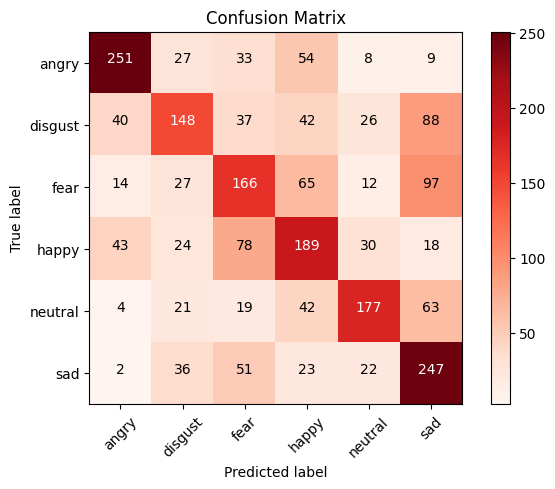

In [89]:
import itertools
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

#2D CNN

In [56]:
training_set = training_set_df
training_labels = training_labels_df
val_set = val_set_df
val_labels = val_labels_df
testing_set = testing_set_df
testing_labels=testing_labels_df

##Get Spectrogram



In [57]:
def get_spectro(audio_path):
    audio_data, sample_rate = librosa.load(audio_path, sr = 16000)
    audio_data = preprocess_audio_mel(audio_data, sample_rate)
    # Adjust the Mel spectrogram parameters
    n_fft = 1024  # Number of FFT points (frame size)
    hop_length = 256  # Hop length (frame shift)
    n_mels = 128  # Number of Mel frequency bins

    # Compute the Mel spectrogram with the adjusted parameters
    mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_fft=1024, hop_length=256, n_mels=128)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
    label=audio_path.partition(".wav")[0].split('_')[2]
    return audio_data, sample_rate, mel_spectrogram_db, mel_spectrogram_db.shape

In [58]:
def prepare_data_mel(data, augment):
    spectrograms = []
    labels = []
    i=0
    for path,emotion in zip (data["Path"],data["Emotion"]):
        if i % 100 == 0:
          print(i)
        i = i+1
        audio_data, sample_rate, mel_spectrogram_db, mel_spectrogram_shape = get_spectro(path)
        spectrograms.append(mel_spectrogram_db)
        labels.append(emotion)
        
        # Data Augmentation
        if augment == True:
          #audio_data, sample_rate = librosa.load(path, sr = 16000)
          #audio_data = truncate_pad(audio_data, 1.024)
          x = audio_data
          mel_spectrogram = librosa.feature.melspectrogram(y = noise(x), sr=sample_rate, n_fft=1024, hop_length=256, n_mels=128)
          mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
          spectrograms.append(mel_spectrogram_db)
          labels.append(emotion)

          x = audio_data
          mel_spectrogram = librosa.feature.melspectrogram(y = pitch(x, sample_rate, 0.7), sr=sample_rate, n_fft=1024, hop_length=256, n_mels=128)
          mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
          spectrograms.append(mel_spectrogram_db)
          labels.append(emotion)

    #print(spectrograms)
    spectrograms = np.array(spectrograms)
    labels = np.array(labels)
    # Reshape the labels to a column vector
    labels = labels.reshape(-1, 1)
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(sparse=False)
    # Perform one-hot encoding
    labels = encoder.fit_transform(labels)
    return spectrograms, labels

##Prepare data

In [59]:
training_specs, training_labels = prepare_data_mel(training_set, True)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [60]:
testing_specs, testing_labels = prepare_data_mel(testing_set, False)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [61]:
val_specs, val_labels = prepare_data_mel(val_set, False)


0
100
200


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [62]:
print(training_specs.shape)
print(training_labels.shape)
print(testing_specs.shape)
print(testing_labels.shape)
print(val_specs.shape)
print(val_labels.shape)

(14844, 128, 65)
(14844, 6)
(2233, 128, 65)
(2233, 6)
(261, 128, 65)
(261, 6)


In [63]:
X_train = training_specs
y_train = training_labels
X_test = testing_specs
y_test = testing_labels
X_val = val_specs
y_val = val_labels

##CNN Model

In [64]:
earlystopping = EarlyStopping(monitor ="val_accuracy",mode = 'auto', patience = 8,restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5,min_lr=0.00001)

model = tf.keras.Sequential([
    L.Conv2D(512, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same'),

    L.Conv2D(256, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='same'),

    L.Conv2D(128, kernel_size=(5, 5), strides=(1, 1), padding='same', activation='relu'),
    L.BatchNormalization(),
    L.MaxPooling2D(pool_size=(5, 5), strides=(2, 2), padding='same'),

    L.Flatten(),
    L.Dense(512, activation='relu'),
    L.Dense(256, activation='relu'),
    L.Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["accuracy", f1_m])
model.summary()
history=model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32,callbacks=[learning_rate_reduction, earlystopping])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 65, 512)      5120      
                                                                 
 batch_normalization_3 (Batc  (None, 128, 65, 512)     2048      
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 33, 512)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 33, 256)       3277056   
                                                                 
 batch_normalization_4 (Batc  (None, 64, 33, 256)      1024      
 hNormalization)                                                 
                                                      

##Test Accuracy

In [65]:
accuracy = model.evaluate(X_test, y_test)

# Print the accuracy
print("Test Accuracy:", accuracy)

70/70 [==============================] - 4s 64ms/step - loss: 2.9719 - accuracy: 0.5540 - f1_m: 0.5516
Test Accuracy: [2.971949577331543, 0.553963303565979, 0.5515758991241455]


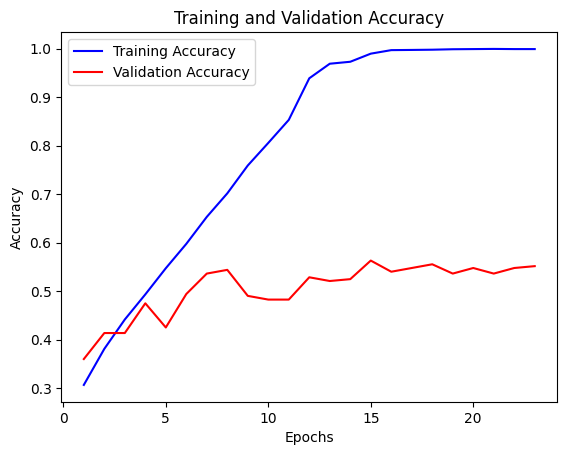

In [66]:
import matplotlib.pyplot as plt

# Get the accuracy values from the history object
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Create a range of epochs
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Confusion Matrix

In [67]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_check = np.argmax(y_test, axis=1)

70/70 [==============================] - 2s 35ms/step


In [68]:
cm = confusion_matrix(y_true=y_check, y_pred=y_pred)

Confusion matrix, without normalization
[[271  40  13  41  11   6]
 [ 56 189  30  15  27  64]
 [ 27  46 151  52  21  84]
 [ 57  42  44 205  18  16]
 [ 16  19  19  21 212  39]
 [  6  75  32  11  48 209]]


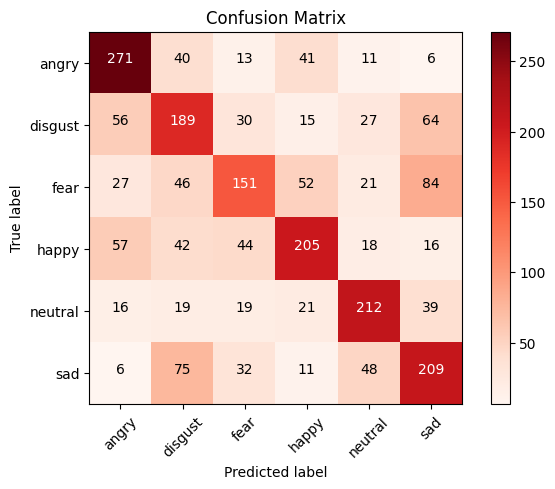

In [69]:
cm_plot_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')